In [1]:
import numpy as np
import torch

/Users/dbm829/anaconda3/envs/sc_mechinterp/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### functions

In [2]:
class RepresentationLayer(torch.nn.Module):
    """
    Implements a representation layer, that accumulates pytorch gradients.

    Representations are vectors in n_rep-dimensional real space. By default
    they will be initialized as a tensor of dimension n_sample x n_rep at origin (zero).

    One can also supply a tensor to initialize the representations (values=tensor).
    The representations will then have the same dimension and will assumes that
    the first dimension is n_sample (and the last is n_rep).

    The representations can be updated once per epoch by standard pytorch optimizers.

    Attributes
    ----------
    n_rep: int
        dimensionality of the representation space
    n_sample: int
        number of samples to be modelled (has to match corresponding dataset)
    z: torch.nn.parameter.Parameter
        tensor of learnable representations of shape (n_sample,n_rep)

    Methods
    ----------
    forward(idx=None)
        takes sample index and returns corresponding representation
    """

    def __init__(self, n_rep: int, n_sample: int, value_init="zero"):
        """Args:
        n_rep: dimensionality of the representation
        n_sample: number of samples to be modelled by the representation
        value_init: per default set to `zero`, leading to an initialization
            of all representations at origin.
            Can also be a tensor of shape (n_sample, n_rep) with custom initialization values
        """
        super(RepresentationLayer, self).__init__()

        self.n_rep = n_rep
        self.n_sample = n_sample

        if value_init == "zero":
            self._value_init = "zero"
            self.z = torch.nn.Parameter(
                torch.zeros(size=(self.n_sample, self.n_rep)), requires_grad=True
            )
        else:
            self._value_init = "custom"
            # Initialize representations from a tensor with values
            assert value_init.shape == (self.n_sample, self.n_rep)
            if isinstance(value_init, torch.Tensor):
                self.z = torch.nn.Parameter(value_init, requires_grad=True)
            else:
                try:
                    self.z = torch.nn.Parameter(
                        torch.Tensor(value_init), requires_grad=True
                    )
                except:
                    raise ValueError(
                        "not able to transform representation init values to torch.Tensor"
                    )

    def forward(self, idx=None):
        """
        Forward pass returns indexed representations
        """
        if idx is None:
            return self.z
        else:
            return self.z[idx]

    def __str__(self):
        return f"""
        RepresentationLayer:
            Dimensionality: {self.n_rep}
            Number of samples: {self.n_sample}
            Value initialization: {self._value_init}
        """

## Have a look

MultivariateNormal(loc: torch.Size([3, 2]), covariance_matrix: torch.Size([3, 2, 2]))
torch.Size([20, 3])


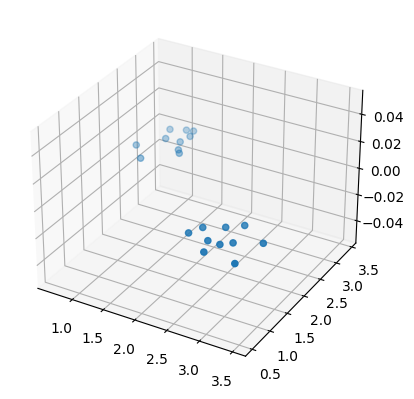

In [97]:
# dummy data: samples from 3 gaussians

dim_sample = 3
dim_rep = 2
n_gaussians = 2

np.random.seed(0)
torch.manual_seed(0)

# generate data
#means = np.random.randn(n_gaussians)
#means = np.array([[1, 1, 1], [2, 2, 2], [3, 3, 3]])
#means = np.array([[1], [2], [3]])

means = torch.ones((dim_sample, n_gaussians))
means[:,1] *= 3
#means[:,2] *= 5
y_distrib = torch.distributions.MultivariateNormal(means, torch.eye(n_gaussians) * 0.1)
print(y_distrib)
n_samples_per_gaussian = 10
n_sample = n_samples_per_gaussian * n_gaussians
y = y_distrib.sample(torch.Size([n_samples_per_gaussian]))
y = y.view(-1, dim_sample)
print(y.shape)
#y = y.view(-1, n_gaussians+dim_sample)

# plot y in 3d
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
#ax.scatter(y[:, 0], y[:, 1], y[:, 2])
ax.scatter(y[:, 0], y[:, 1])
plt.show()

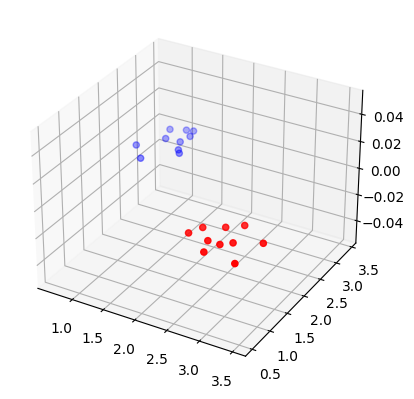

In [113]:
#colors = ['blue'] * 10 + ['red'] * 10
colors = ['blue', 'red'] * 10

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
#ax.scatter(y[:, 0], y[:, 1], y[:, 2])
ax.scatter(y[:, 0], y[:, 1], c=colors)
plt.show()

In [98]:
y.shape

torch.Size([20, 3])

In [104]:
# create representations

rep = RepresentationLayer(n_rep=dim_rep, n_sample=n_sample)

In [105]:
# create a small neural network to predict the samples from the representations

class Net(torch.nn.Module):
    def __init__(self, dim_rep, dim_sample):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(dim_rep, 10)
        self.fc2 = torch.nn.Linear(10, dim_sample)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = Net(dim_rep, dim_sample)

In [106]:
# create an optimizer for the representations and the network
optim = torch.optim.Adam(net.parameters(), lr=0.01)
rep_optim = torch.optim.Adam(rep.parameters(), lr=0.01)

n_epochs = 10
n_batches = n_sample // 10

# create a placeholder to store representation gradients
rep_gradients = torch.zeros((n_sample, dim_rep, n_epochs, n_batches))
# train the network
for epoch in range(10):
    optim.zero_grad()
    rep_optim.zero_grad()
    # create batches of 10 samples
    for i in range(0, n_sample, 10):
        indices = torch.arange(i, i + 10)
        y_pred = net(rep(indices))
        loss = torch.nn.functional.mse_loss(y_pred, y[indices])
        loss.backward()
        # get the representation gradients
        with torch.no_grad():
            rep_gradients[indices, :, epoch, i // 10] = rep.z.grad[indices,:].clone()
        optim.step()
    rep_optim.step()

In [109]:
rep_gradients

tensor([[[[ 3.4177e-03,  0.0000e+00],
          [ 9.8770e-03,  0.0000e+00],
          [ 1.6272e-02,  0.0000e+00],
          [ 2.2461e-02,  0.0000e+00],
          [ 2.8585e-02,  0.0000e+00],
          [ 3.4750e-02,  0.0000e+00],
          [ 4.0937e-02,  0.0000e+00],
          [ 4.7104e-02,  0.0000e+00],
          [ 5.3187e-02,  0.0000e+00],
          [ 5.9102e-02,  0.0000e+00]],

         [[ 8.8029e-03,  0.0000e+00],
          [ 7.0494e-03,  0.0000e+00],
          [ 5.8613e-03,  0.0000e+00],
          [ 4.8401e-03,  0.0000e+00],
          [ 4.1449e-03,  0.0000e+00],
          [ 3.8601e-03,  0.0000e+00],
          [ 3.9777e-03,  0.0000e+00],
          [ 4.4767e-03,  0.0000e+00],
          [ 5.3308e-03,  0.0000e+00],
          [ 6.5078e-03,  0.0000e+00]]],


        [[[ 2.7346e-04,  0.0000e+00],
          [ 1.1946e-02,  0.0000e+00],
          [ 2.3227e-02,  0.0000e+00],
          [ 3.4319e-02,  0.0000e+00],
          [ 4.5737e-02,  0.0000e+00],
          [ 5.7609e-02,  0.0000e+00],
      

In [116]:
rep_gradients.shape

torch.Size([20, 2, 10, 2])

In [118]:
# compute the average length of each vector

def compute_vector_length(v, axis=None):
    return torch.sqrt(torch.sum(v ** 2, axis))

grad_lengths = compute_vector_length(rep_gradients, axis=1).sum(-1)
grad_lengths.shape

torch.Size([20, 10])

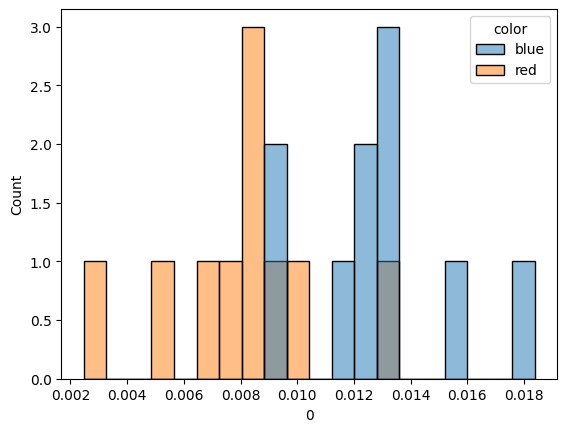

In [124]:
# plot the gradient lengths by color

grad_length_list = []
grad_length_colors = []
for i in range(10):
    grad_length_list.extend(grad_lengths[:, i].tolist())
    grad_length_colors.extend(colors)

import pandas as pd
df_grad_lengths = pd.DataFrame(grad_lengths.numpy())
df_grad_lengths['color'] = colors
import seaborn as sns
fig = plt.figure()
sns.histplot(data=df_grad_lengths, x=0, hue='color', bins=20)
plt.show()